**Übung Mustererkennung** *WS 2022/23* -- *K. Brandenbusch,  Gernot A. Fink* -- *Technische Universität Dortmund, Lehrstuhl XII, Mustererkennung in eingebetteten Systemen*
___
# Aufgabe 2: Bayes'sche Normalverteilungs-Klassifikator

**Achtung:** Gestalten Sie Ihre Implementierung so, dass die Klassifikatoren für zukünftige Aufgaben wiederverwendet werden können.

Zuerst muss das Notebook konfiguriert werden.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

# Uebergeordneten Ordner zum Pfad hinzufuegen, damit das common Package importiert werden kann
import sys
if '..' not in sys.path:
    sys.path.append('..')


In dieser Aufgabe soll ein Bayes'scher Normalverteilungs-Klassifikator mit drei Dichten realisiert werden.

Bestimmen Sie als erstes die Menge an unterschiedlichen Klassen-Labels und speichern Sie diese in der lokalen Variable `labels`.

Nützliche Funktionen:
- [numpy.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html)

In [2]:
from common.data_provider import DataProvider
import numpy as np

train_data_provider = DataProvider(DataProvider.DATA2DROOT_TRAIN)
train_data, train_labels = train_data_provider.get_dataset_and_labels()
labels = np.unique(train_labels)
print(labels)



['0' '1' '2']


### Normalverteilungen
Berechnen Sie Mittelwert und Kovarianz der drei Klassen durch Matrixoperationen in NumPy.
Speichern Sie für jeden Schleifendurchlauf den Mittelwert in der lokalen Variablen `mean` und die Kovarianzmatrix in der lokalen Variablen `cov`.
Benutzen Sie zur Schätzung die [korrigierte Kovarianzmatrix](https://de.wikipedia.org/wiki/Stichprobenkovarianz#Korrigierte_Stichprobenkovarianz).

In [54]:
mean_list = []
cov_list = []
for label in labels:
    class_data = train_data_provider.get_class_arr(class_idx=label)
    #print(class_data)
    # Berechnen Sie mean und cov hier
    class_data_len = len(class_data)
    mean = np.sum(class_data, axis=0) / class_data_len
    cov = np.dot(np.transpose(class_data-mean), class_data-mean) / (class_data.shape[0]-1)
    np.testing.assert_almost_equal(actual=mean,
                                   desired=np.mean(class_data, axis=0),
                                   err_msg='Der Mittelwert ist falsch')
    np.testing.assert_almost_equal(actual=cov,
                                   desired=np.cov(class_data, rowvar=0),
                                   err_msg='Die Kovarianzmatrix ist falsch')
    mean_list.append(mean)
    cov_list.append(cov)

print(f"mean_list: {mean_list}")
print(f"cov_list: {cov_list}")

mean_list: [array([-0.00527639,  1.02526442]), array([-1.9171771 ,  1.30835853]), array([-3.02371709,  3.05199424])]
cov_list: [array([[ 1.0008819 , -0.02464601],
       [-0.02464601,  0.99233498]]), array([[19.43507019,  0.16483493],
       [ 0.16483493,  6.80692733]]), array([[1.97403343, 0.10108077],
       [0.10108077, 2.02657379]])]


Visualisieren Sie die Datenpunkte der drei Klassen, sowie die geschätzen Mittelwerte und Kovarianzmatrizen durch eine Normalverteilung.
Zur Visualisierung der Normalverteilungen steht Ihnen im Modul [`common.visualization`](../common/visualization.py) die Methode `plot_norm_dist_ellipse` zur Verfügung.

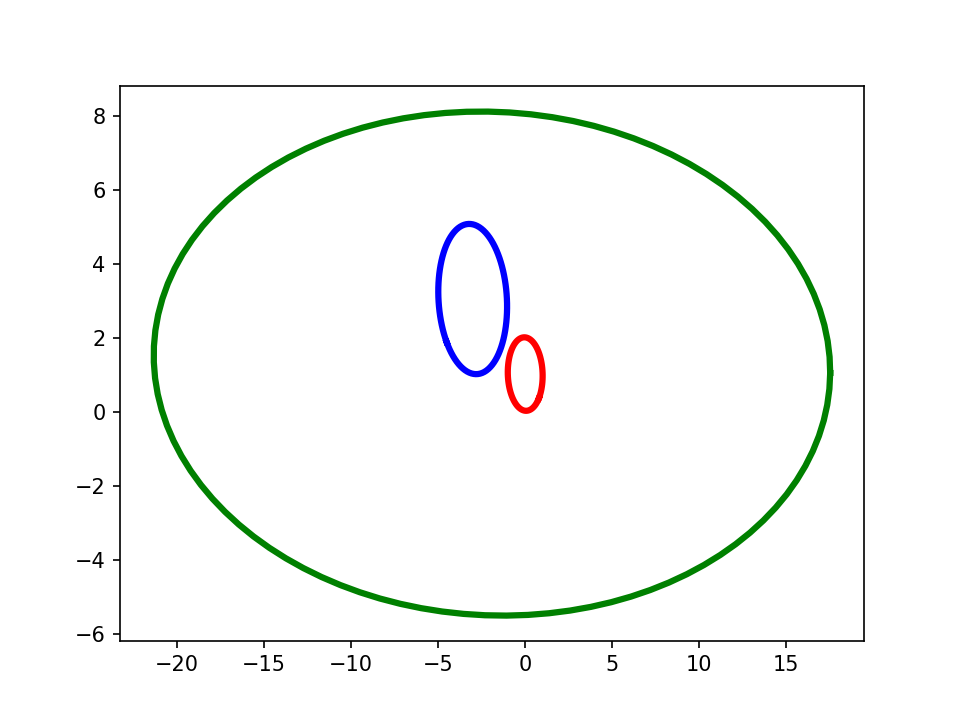

In [53]:
import matplotlib.pyplot as plt
from common import visualization

_, ax = plt.subplots(dpi=150)

visualization.plot_norm_dist_ellipse(ax, mean_list, cov_list, ['r','g','b'])

---
### Bayes-Klassifikator
Ein Bayes-Klassifikator weist einen Merkmalsvektor $\underline c$ einer Klasse $\Omega_k$ nach maximaler a-posteriori Warscheinlichkeit $\large p(\Omega_k \mid \underline c)$ zu.
Unter der Verwendung der *Bayes-Regel* lässt sich diese berechnen durch:

$$
    \large p(\Omega_K \mid \underline c) = \frac{p(\Omega_k)p(\underline c \mid \Omega_k)}{p(\underline c)}.
$$

Da für die Entscheidungsregel nur die größte Wahrscheinlichkeit interessant ist, lässt sich diese vereinfachen:
$$
    \large \text{argmax}_{\Omega_k} p(\Omega_k \mid \underline c)  \simeq p(\Omega_k)p(\underline c \mid \Omega_k).
$$

Die klassenbedingte Dichte soll hier als eine Normalverteilung (pro Klasse) realisiert werden:
$$
    \large p(\underline c \mid \Omega_k) = \mathcal N (\underline c \mid \mu_k, \Sigma_k).
$$


#### Schätzen
Implementieren Sie nun die Methode `estimate` der Klasse `GaussianClassifier` im Modul [`common.classification`](../common/classification.py).

Hinweis: Achten Sie darauf, dass Ihre Implementierung unabhängig von den hier genutzten Klassenlabels ist (sowohl Anzahl der unterschiedlichen Labels als auch Namen).

In [34]:
from common.classification import GaussianClassifier
bayes = GaussianClassifier()
bayes.estimate(train_data, train_labels)

[array([-0.00527639,  1.02526442]), array([-1.9171771 ,  1.30835853]), array([-3.02371709,  3.05199424])]


#### Klassifizieren
Nachdem ihr Bayes-Klassifikator implementiert und geschätzt wurde ist er bereit für die Klassifikation.
Implementieren Sie nun die Methode `classify` der Klasse `GaussianClassifier` im Modul [`common.classification`](../common/classification.py).

*Achtung:* da bei der Berechnung eine Multiplikation vieler Wahrscheinlichkeiten ($0<p<1$) durchgeführt wird besteht die Gefahr eines [Arithmetischen Unterlaufs](https://de.wikipedia.org/wiki/Arithmetischer_Unterlauf).
Welche Maßnahmen müssen Sie ergreifen um dies zu verhindern?

In [51]:
test_data_provider = DataProvider(DataProvider.DATA2DROOT_TEST)
test_data, test_labels_gt = test_data_provider.get_dataset_and_labels()

estimated_labels = bayes.classify(test_data)

Iteration: 0 | Wht: 0.11977386633349926 | Label: 0
Iteration: 1 | Wht: 0.1278810068094866 | Label: 0
Iteration: 2 | Wht: 0.054083060640772715 | Label: 2
Iteration: 3 | Wht: 0.1319869653690556 | Label: 0
Iteration: 4 | Wht: 0.11948248903459993 | Label: 0
Iteration: 5 | Wht: 0.09473517497266018 | Label: 0
Iteration: 6 | Wht: 0.10536033101787204 | Label: 0
Iteration: 7 | Wht: 0.03145986500878869 | Label: 0
Iteration: 8 | Wht: 0.07272872336334293 | Label: 0
Iteration: 9 | Wht: 0.1035910626041266 | Label: 0
Iteration: 10 | Wht: 0.07847375959517985 | Label: 0
Iteration: 11 | Wht: 0.13062065594636593 | Label: 0
Iteration: 12 | Wht: 0.11934112462709962 | Label: 0
Iteration: 13 | Wht: 0.052916730813300894 | Label: 2
Iteration: 14 | Wht: 0.09009775454547675 | Label: 0
Iteration: 15 | Wht: 0.11532694493413936 | Label: 0
Iteration: 16 | Wht: 0.1322952088906712 | Label: 0
Iteration: 17 | Wht: 0.12635842669887462 | Label: 0
Iteration: 18 | Wht: 0.060157722501880825 | Label: 0
Iteration: 19 | Wht: 0.

---
### Evaluation
Führen Sie eine Evaluierung des Klassifikators wie in Aufgabe 1 durch.


In [52]:
from common.classification import ClassificationEvaluator

bayesEvali = ClassificationEvaluator(estimated_labels, test_labels_gt)
bayesEvali.print_results()

Fehlerrate: 31.3; Anzahl falsch-klassifizierte Muster: 625; Anzahl Muster: 1998
Klassenspezifische Fehlerraten
Klasse 0:	Fehlerrate: 8.9;	Anzahl falsch-klassifizierte Muster:  59;	Anzahl Muster: 666
Klasse 1:	Fehlerrate: 70.6;	Anzahl falsch-klassifizierte Muster: 470;	Anzahl Muster: 666
Klasse 2:	Fehlerrate: 14.4;	Anzahl falsch-klassifizierte Muster:  96;	Anzahl Muster: 666


Vergleichen Sie die Ergebnisse mit dennen des $k$-NN-Klassifikators.

Diskutieren sie Vor- und Nachteile der beiden Modelle.